In [ ]:
data = "/content/sales_data.csv"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor

In [ ]:
df = pd.read_csv(data)

In [ ]:
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Seasonality,Epidemic,Demand
0,01-01-2022,S001,P0001,Electronics,North,195,102,252,72.72,5,Snowy,0,85.73,Winter,0,115
1,01-01-2022,S001,P0002,Clothing,North,117,117,249,80.16,15,Snowy,1,92.02,Winter,0,229
2,01-01-2022,S001,P0003,Clothing,North,247,114,612,62.94,10,Snowy,1,60.08,Winter,0,157
3,01-01-2022,S001,P0004,Electronics,North,139,45,102,87.63,10,Snowy,0,85.19,Winter,0,52
4,01-01-2022,S001,P0005,Groceries,North,152,65,271,54.41,0,Snowy,0,51.63,Winter,0,59


In [ ]:
df.columns

Index(['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Price', 'Discount',
       'Weather Condition', 'Promotion', 'Competitor Pricing', 'Seasonality',
       'Epidemic', 'Demand'],
      dtype='object')

In [ ]:
df.shape

(76000, 16)

In [ ]:
#convert date column
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values('Date').reset_index(drop=True)
df.set_index('Date', inplace=True)
print(df.index.min(), df.index.max())

2022-01-01 00:00:00 2024-01-30 00:00:00


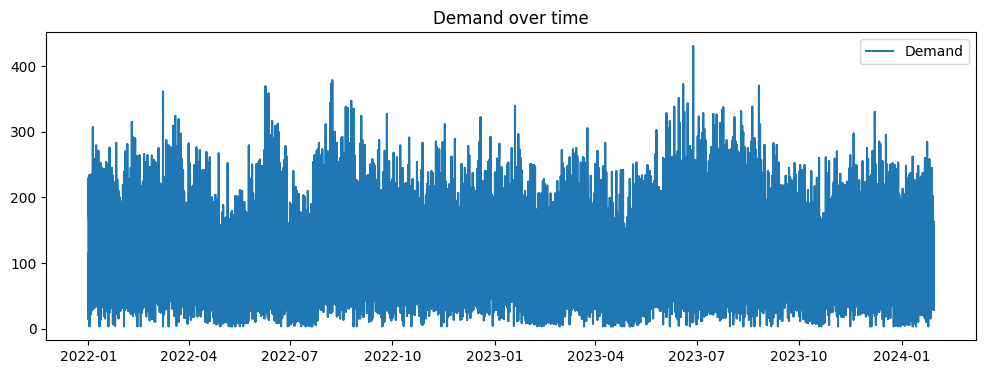

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df.index, df['Demand'], label='Demand')
plt.title('Demand over time')
plt.legend()
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['Weather Condition', 'Promotion', 'Region', 'Weather Condition', 'Seasonality']
encoder = LabelEncoder()

for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])


In [ ]:
df

,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Seasonality,Epidemic,Demand
Date,,,,,,,,,,,,,,,
2022-01-01,S001,P0001,Electronics,1,195,102,252,72.72,5,2,0,85.73,3,0,115
2022-01-01,S004,P0013,Groceries,3,136,104,385,20.24,10,2,0,18.90,3,0,110
2022-01-01,S004,P0012,Electronics,3,111,111,113,118.15,0,2,0,133.46,3,0,103
2022-01-01,S004,P0011,Clothing,3,195,60,293,52.89,0,2,0,62.29,3,0,61
2022-01-01,S004,P0010,Groceries,3,223,120,597,30.02,0,2,0,29.15,3,0,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-30,S002,P0008,Groceries,2,85,81,94,26.98,0,2,0,24.65,3,0,96
2024-01-30,S002,P0007,Toys,2,414,126,0,26.84,10,2,0,29.55,3,0,109
2024-01-30,S002,P0006,Clothing,2,98,96,117,63.58,10,2,0,76.22,3,0,118


In [ ]:
# Encode categorical features consistently
data_encoded = pd.get_dummies(data, columns=['Seasonality'], drop_first=False)

In [ ]:
#lag featrues
df['lag_1'] = df['Demand'].shift(1)
df['lag_2'] = df['Demand'].shift(2)
df['lag_3'] = df['Demand'].shift(3)

In [ ]:
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek
df['year'] = df.index.year

In [ ]:
df.dropna(inplace=True)
print("Final dataset shape:", df.shape)

Final dataset shape: (75997, 21)


In [ ]:
df.columns

Index(['Store ID', 'Product ID', 'Category', 'Region', 'Inventory Level',
       'Units Sold', 'Units Ordered', 'Price', 'Discount', 'Weather Condition',
       'Promotion', 'Competitor Pricing', 'Seasonality', 'Epidemic', 'Demand',
       'lag_1', 'lag_2', 'lag_3', 'month', 'dayofweek', 'year'],
      dtype='object')

In [ ]:
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test  = df.iloc[train_size:]

In [ ]:
feature_cols = ['month', 'dayofweek', 'year', 'Units Sold', 'Units Ordered', 'Price', 'Discount', 'Promotion', 'Seasonality']

In [ ]:
feature_cols = ['lag_1', 'lag_2', 'lag_3', 'month', 'dayofweek', 'year', 'Units Sold', 'Units Ordered', 'Price', 'Discount', 'Promotion', 'Seasonality']

In [ ]:
df

,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,...,Competitor Pricing,Seasonality,Epidemic,Demand,lag_1,lag_2,lag_3,month,dayofweek,year
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,S004,P0011,Clothing,3,195,60,293,52.89,0,2,...,62.29,3,0,61,103.0,110.0,115.0,1,5,2022
2022-01-01,S004,P0010,Groceries,3,223,120,597,30.02,0,2,...,29.15,3,0,128,61.0,103.0,110.0,1,5,2022
2022-01-01,S004,P0009,Clothing,3,206,106,299,110.47,5,2,...,122.04,3,0,98,128.0,61.0,103.0,1,5,2022
2022-01-01,S004,P0008,Furniture,3,281,59,0,100.64,0,2,...,118.02,3,0,80,98.0,128.0,61.0,1,5,2022
2022-01-01,S004,P0007,Groceries,3,185,43,253,24.34,5,2,...,26.46,3,0,65,80.0,98.0,128.0,1,5,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-30,S002,P0008,Groceries,2,85,81,94,26.98,0,2,...,24.65,3,0,96,108.0,107.0,62.0,1,1,2024
2024-01-30,S002,P0007,Toys,2,414,126,0,26.84,10,2,...,29.55,3,0,109,96.0,108.0,107.0,1,1,2024
2024-01-30,S002,P0006,Clothing,2,98,96,117,63.58,10,2,...,76.22,3,0,118,109.0,96.0,108.0,1,1,2024


In [ ]:
xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42)

In [ ]:
xgb_base.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
base_preds = xgb_base.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
mape = mean_absolute_percentage_error(y_test, base_preds)
r2 = r2_score(y_test, base_preds)
print("Before lag feature")
print(f"Baseline MAPE: {mape:.4f}")
print(f"Baseline R-squared: {r2:.4f}")

Before lag feature
Baseline MAPE: 0.2362
Baseline R-squared: 0.7796


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
mape = mean_absolute_percentage_error(y_test, base_preds)
r2 = r2_score(y_test, base_preds)
print("After lag feature")
print(f"Baseline MAPE: {mape:.4f}")
print(f"Baseline R-squared: {r2:.4f}")

After lag feature
Baseline MAPE: 0.2362
Baseline R-squared: 0.7796


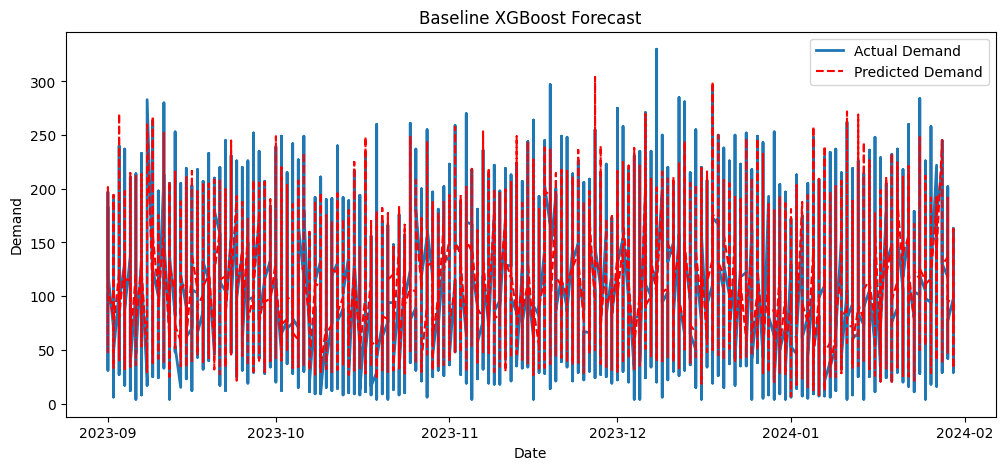

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test.index, y_test, label='Actual Demand', linewidth=2)
plt.plot(test.index, base_preds, label='Predicted Demand', color='red', linestyle='--')
plt.title('Baseline XGBoost Forecast')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("✅ Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
✅ Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [ ]:
best_params = grid_search.best_params_
final_model = XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
final_model.fit(X_train, y_train)
final_preds = final_model.predict(X_test)

In [ ]:
final_mape = mean_absolute_percentage_error(y_test, final_preds)
final_r2 = r2_score(y_test, final_preds)
print(f"Final R2: {final_r2:.4f}")
print(f"Final MApE: {final_mape:.4f}")

Final R2: 0.7953
Final MApE: 0.2182


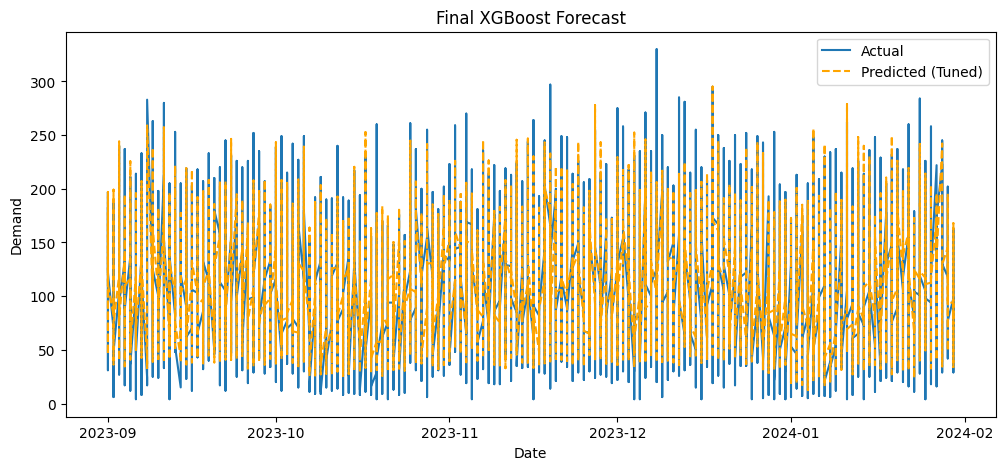

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, final_preds, label='Predicted (Tuned)', color='orange', linestyle='--')
plt.title('Final XGBoost Forecast')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

In [ ]:
##future prediction
future_steps = 10
last_row = df.iloc[-1:].copy()
future_predictions = []

# list of one-hot encoded seasonality columns from the training data
seasonality_cols = [col for col in X_train.columns if 'Seasonality_' in col]

# last known seasonality label from the original df
last_seasonality_label = df.iloc[-1]['Seasonality']

for i in range(future_steps):

    X_input_row_base = last_row[[col for col in feature_cols if col != 'Seasonality']].copy()
    future_seasonality_label = last_seasonality_label
    temp_df = pd.DataFrame({'Seasonality': [future_seasonality_label]})
    seasonality_one_hot = pd.get_dummies(temp_df, columns=['Seasonality'], prefix='Seasonality', drop_first=True)

    for col in seasonality_cols:
        if col not in seasonality_one_hot.columns:
            seasonality_one_hot[col] = 0
    X_input_row = pd.concat([X_input_row_base.reset_index(drop=True), seasonality_one_hot.reset_index(drop=True)], axis=1)
    X_input_row = X_input_row.reindex(columns=X_train.columns, fill_value=0)

    X_input = X_input_row.values.reshape(1, -1)

    next_pred = final_model.predict(X_input)[0]
    future_predictions.append(next_pred)
    last_row['lag_3'] = last_row['lag_2'].values[0]
    last_row['lag_2'] = last_row['lag_1'].values[0]
    last_row['lag_1'] = next_pred

    # Increment date and update date-related features in last_row for the next iteration
    new_date = last_row.index[0] + pd.Timedelta(days=1)
    last_row.index = [new_date]
    last_row['month'] = new_date.month
    last_row['dayofweek'] = new_date.dayofweek
    last_row['year'] = new_date.year

print("Next 10-day demand forecast:")
print(future_predictions)

Next 10-day demand forecast:
[np.float32(73.73322), np.float32(73.558334), np.float32(69.24673), np.float32(69.096115), np.float32(69.03466), np.float32(68.62958), np.float32(68.62958), np.float32(68.39217), np.float32(68.39861), np.float32(68.39861)]


In [ ]:
print(future_predictions)

[np.float32(73.73322), np.float32(73.558334), np.float32(69.24673), np.float32(69.096115), np.float32(69.03466), np.float32(68.62958), np.float32(68.62958), np.float32(68.39217), np.float32(68.39861), np.float32(68.39861)]
